In [1]:
import networkx as nx
import numpy as np
import fugu
from fugu import Scaffold, Brick
from fugu.bricks import Vector_Input
from fugu.backends import snn_Backend

import os
import yaml
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})

In [2]:
## Note: the contents of this notebook are for converting a fugu network to STACS
##       more directly, which may be helpful for troubleshooting how to interface
##       with potentially new input formats.
##       This functionality is encapsulated within a Fugu backend for ease of use
##
## Note: there are some variables, such as the path to the local installation
##       of the STACS executable that may need to be changed for your local system

stacs_bin = '/ascldap/users/mkrygie/repos/stacs/stacs' # Set parameter to your stacs directory

# Fugu Circuit

### This is just an example circuit (streaming adder)

In [3]:
class streaming_adder(Brick):
    
    """
    streaming adder function. 
    Brad Aimone
    jbaimon@sandia.gov
    
    """
    
    def __init__(self, name=None):
        super().__init__()
        self.is_built = False
        self.dimensionality = {'D': 2}
        self.name = name
        self.supported_codings = ['binary-L']
        
    def build(self, graph, dimensionality, control_nodes, input_lists, input_codings):
        """
        Build streaming adder brick. 

        Arguments:
            + graph - networkx graph to define connections of the computational graph
            + dimensionality - dictionary to define the shapes and parameters of the brick
            + control_nodes - dictionary of lists of auxillary networkx nodes.  Excpected keys: 'complete' - A list of neurons that fire when the brick is done
            + input_lists - list of nodes that will contain input
            + input_coding - list of input coding formats

        Returns:
            + graph of a computational elements and connections
            + dictionary of output parameters (shape, coding, layers, depth, etc)
            + dictionary of control nodes ('complete')
            + list of output
            + list of coding formats of output
        """
        
        if len(input_codings) != 2:
            raise ValueError("adder takes in 2 input on size n")
            
        output_codings = [input_codings[0]]
        
        new_complete_node_name = self.name + '_complete'
        new_begin_node_name = self.name + '_begin'
        
        graph.add_node(new_begin_node_name, index = -2, threshold = 0.0, decay =0.0, p=1.0, potential=0.0)
        graph.add_node(new_complete_node_name,
                      index = -1,
                      threshold = .9,
                      decay =0.0,
                      p=1.0,
                      potential=0.0)
        

        graph.add_edge(control_nodes[0]['complete'], new_complete_node_name, weight=0.5, delay=3)
        graph.add_edge(control_nodes[1]['complete'], new_complete_node_name, weight=0.5, delay=3)

        graph.add_edge(control_nodes[0]['begin'], new_begin_node_name, weight=1.0, delay=2)

        complete_node = new_complete_node_name
        begin_node = new_begin_node_name
        
     
        l = len(input_lists[0])
        
        #nodes
        graph.add_node(self.name + 'add', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry0', threshold=1.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'carry1', threshold=2.9, decay=1.0, p=1.0, potential=0.0)
        graph.add_node(self.name + 'out', threshold=.9, decay=1.0, p=1.0, potential=0.0)
        #edges
        graph.add_edge(input_lists[0][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(input_lists[0][0], self.name + 'carry1', weight=1.0, delay=1)
        graph.add_edge(input_lists[1][0], self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'carry0', self.name + 'add', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry0', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'carry1', weight=1.0, delay=1)
        
        graph.add_edge(self.name + 'add', self.name + 'out', weight=1.0, delay=1)
        graph.add_edge(self.name + 'carry0', self.name + 'out', weight=-1.0, delay=1)
        graph.add_edge(self.name + 'carry1', self.name + 'out', weight=1.0, delay=1)
        
        self.is_built=True
        
        output_lists = [[self.name + 'out']]
        
        return (graph, self.dimensionality, [{'complete': complete_node, 'begin': begin_node}], output_lists, output_codings)
    

In [4]:
# Simple addition example

scaffold = Scaffold()

# For addition, what we want to do is create a Scaffold taking two inputs and the adder brick
a=[1, 1, 0, 1, 1, 0, 1, 1]
b=[1, 1, 0, 1, 1, 0, 1, 1]
#a=[1, 1]
#b=[0, 1]
scaffold.add_brick(Vector_Input(np.array([a]), coding='binary-L', name='Input0', time_dimension = True), 'input' )
scaffold.add_brick(Vector_Input(np.array([b]), coding='binary-L', name='Input1', time_dimension = True), 'input' )
scaffold.add_brick(streaming_adder(name='adder1_'), [(0,0), (1, 0)], output=True)

scaffold.lay_bricks()
scaffold.summary(verbose=1)

backend = snn_Backend()
backend_args = {}
backend_args['record'] = 'all'
backend_args['debug_mode'] = True
backend.compile(scaffold, backend_args)
result = backend.run(30)
print(result)

Scaffold is built: True
-------------------------------------------------------
List of Bricks:


Brick No.: 0
Brick Tag: Input0-0
Brick Name: Input0
{'tag': 'Input0-0', 'name': 'Input0', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7fa8ce6d4710>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input0-0:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 8)], 'output_coding': 'binary-L', 'layer': <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x7fa9045a3f50>>, 'D': 0}, 'control_nodes': [{'complete': 'Input0-0:complete', 'begin': 'Input0-0:begin'}]}
Brick is built: True


Brick No.: 1
Brick Tag: Input1-1
Brick Name: Input1
{'tag': 'Input1-1', 'name': 'Input1', 'brick': <fugu.bricks.input_bricks.Vector_Input object at 0x7fa8ce6d4750>, 'layer': 'input', 'input_nodes': [(-2, 0)], 'output_lists': [['Input1-1:(0,)']], 'output_codings': ['binary-L'], 'metadata': {'output_shape': [(1, 8)], 'output_coding': 'bin

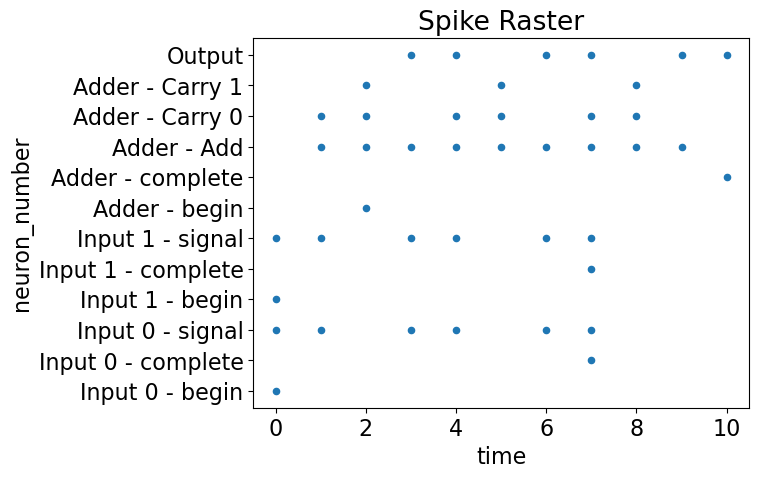

In [5]:
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plt.yticks(np.arange(12), ['Input 0 - begin', 'Input 0 - complete', 'Input 0 - signal', 'Input 1 - begin', 'Input 1 - complete', 'Input 1 - signal', 'Adder - begin', 'Adder - complete', 'Adder - Add', 'Adder - Carry 0', 'Adder - Carry 1', 'Output'])
plt.show()

# Conversion to STACS

### The handling of Input Bricks may change depending on the brick type

In [6]:
# Moving from NetworkX graph to STACS input files

# Config information and file paths
netwkdir = './fugunet'
fugufiles = netwkdir + '/files'
recordir = netwkdir + '/record'
filebase = 'fugunet'
npdat = 2
npnet = 2
nprun = 2

# Simulation arguments
charmrun = stacs_bin + '/' + 'charmrun'
charm_pe = "+p" + str(nprun)
stacs = stacs_bin + '/' + 'stacs'
runconf = netwkdir + '/' + filebase + '.yml'

# Command to run
runcmd = charmrun + ' ' + charm_pe + ' ' + stacs + ' ' + runconf
print(runcmd)

# Some helper data structures for the conversion
neuronindex = {}
neuronmap = {}
neuronname = {}
for i, neuron in enumerate(scaffold.graph.nodes):
    neuronindex[neuron] = i
    neuronname[str(neuron)] = i
    neuronmap[i] = neuron

neuron_default = {'v':0.0,'v_thresh':0.0,'v_reset':0.0,'v_bias':0.0,'v_leak':1.0,'p_spike':1.0,'I_syn':0.0}

/ascldap/users/mkrygie/repos/stacs/stacs/charmrun +p2 /ascldap/users/mkrygie/repos/stacs/stacs/stacs ./fugunet/fugunet.yml


In [7]:
# Input Neurons require both control nodes and output lists
input_neurons = []
input_spikes = {}

for brick in scaffold.circuit.nodes:
    if 'layer' in scaffold.circuit.nodes[brick] and scaffold.circuit.nodes[brick]['layer'] == 'input':
        # Control Nodes
        print(scaffold.circuit.nodes[brick]['control_nodes'][0]['begin'])
        neuron = scaffold.circuit.nodes[brick]['control_nodes'][0]['begin']
        input_neurons.append(neuronindex[neuron])
        input_spikes[neuronindex[neuron]] = list([1])
        # Need to update the default potential for synchronization of timing
        # (instead of spiking due to initial potential, spike when inputs arrive)
        scaffold.graph.nodes[scaffold.circuit.nodes[brick]['control_nodes'][0]['begin']]['potential'] = 0.0
        # Output Lists
        print(scaffold.circuit.nodes[brick]['output_lists'])
        for l, lists in enumerate(scaffold.circuit.nodes[brick]['output_lists']):
            for n, neuron in enumerate(lists):
                input_neurons.append(neuronindex[neuron])
                # TODO: what happens with multi-dimensional vectors?
                input_spikes[neuronindex[neuron]] = (scaffold.circuit.nodes[brick]['brick'].vector[n]).tolist()

input_neurons.sort() # This gets them in neuron order

event_list = []
spike_input = {}
for neuron in input_neurons:
    evtlist = []
    ts = 0
    for spike in input_spikes[neuron]:
        if spike == 1:
            evtlist.append(ts)
        ts += 1
    event_list.append(evtlist)
spike_input["spike_list"] = event_list
with open(fugufiles + "/fugu_input.yml","w") as file:
    yaml.dump(spike_input,file)
    
with open(fugufiles + '/fugu_input.csv','w') as fp_inp:
    for neuron in range(scaffold.graph.number_of_nodes()):
        if neuron in input_neurons:
            fp_inp.write('0\n')
        else:
            fp_inp.write('\n')

Input0-0:begin
[['Input0-0:(0,)']]
Input1-1:begin
[['Input1-1:(0,)']]


In [8]:
# Convert graph to sparse-csv files for stacs to build with
# This essentially all gets converted into a flat population
with open(fugufiles + '/fugu_v.csv','w') as fp_v, open(fugufiles + '/fugu_v_thresh.csv','w') as fp_vt, \
        open(fugufiles + '/fugu_v_reset.csv','w') as fp_vr, open(fugufiles + '/fugu_v_bias.csv','w') as fp_vb, \
        open(fugufiles + '/fugu_v_leak.csv','w') as fp_vl, open(fugufiles + '/fugu_p_spike.csv','w') as fp_ps,  \
        open(fugufiles + '/fugu_I_syn.csv','w') as fp_is, open(fugufiles + '/fugu_vtxname.csv','w') as fp_vn:
            for neuron in scaffold.graph.nodes:
                if 'potential' in scaffold.graph.nodes[neuron]:
                    fp_v.write(str(scaffold.graph.nodes[neuron]['potential'])+'\n')
                else:
                    fp_v.write(str(neuron_default['v'])+'\n')
                if 'threshold' in scaffold.graph.nodes[neuron]:
                    fp_vt.write(str(scaffold.graph.nodes[neuron]['threshold'])+'\n')
                else:
                    fp_vt.write(str(neuron_default['v_thresh'])+'\n')
                if 'reset_voltage' in scaffold.graph.nodes[neuron]:
                    fp_vr.write(str(graph.nodes[neuron]['reset_voltage'])+'\n')
                else:
                    fp_vr.write(str(neuron_default['v_reset'])+'\n')
                if 'bias' in scaffold.graph.nodes[neuron]:
                    fp_vb.write(str(scaffold.graph.nodes[neuron]['bias'])+'\n')
                else:
                    fp_vb.write(str(neuron_default['v_bias'])+'\n')
                if 'decay' in scaffold.graph.nodes[neuron]:
                    fp_vl.write(str(scaffold.graph.nodes[neuron]['decay'])+'\n')
                else:
                    fp_vl.write(str(neuron_default['v_leak'])+'\n')
                if 'p' in scaffold.graph.nodes[neuron]:
                    fp_ps.write(str(scaffold.graph.nodes[neuron]['p'])+'\n')
                else:
                    fp_ps.write(str(neuron_default['p_spike'])+'\n')
                if 'current' in scaffold.graph.nodes[neuron]: # current doesn't actually exist
                    fp_is.write(str(scaffold.graph.nodes[neuron]['current'])+'\n')
                else:
                    fp_is.write(str(neuron_default['I_syn'])+'\n')
                fp_vn.write(str(neuron)+'\n')
                               
# Connection weights and delays
with open(fugufiles + '/fugu_weight.csv','w') as fp_wgt, open(fugufiles + '/fugu_delay.csv','w') as fp_del:
    for i, neuron in enumerate(scaffold.graph.nodes):
        # Might need some sorting first?
        for edge in scaffold.graph.in_edges(neuron):
            fp_wgt.write(str(neuronindex[edge[0]]) + ':' + str(scaffold.graph.edges[edge]['weight']) + ',')
            fp_del.write(str(neuronindex[edge[0]]) + ':' + str(scaffold.graph.edges[edge]['delay']) + ',')
        fp_wgt.write('\n')
        fp_del.write('\n')

In [9]:
# Update the network configuration files to have the correct neuron and input numbers

# Modify the model configuration
fname = netwkdir + '/' + filebase + '.model'
modelconfig = []
with open(fname,"r") as file:
    modelymls = yaml.safe_load_all(file)
    for modelyml in modelymls:
        modelconfig.append(modelyml)
# 0 is the records file, 1 is the fugu neurons population
modelconfig[1]['param'][0]['value'] = len(event_list)
with open(fname,"w") as file:
    yaml.dump_all(modelconfig,file,sort_keys=False)
    
# Modify the graph configuration
fname = netwkdir + '/' + filebase + '.graph'
with open(fname,"r") as file:
    graphconfig = yaml.safe_load(file)
# Update the number of neurons in the population
graphconfig['vertex'][0]['order'] = len(neuronindex)
with open(fname,"w") as file:
    yaml.dump(graphconfig,file,sort_keys=False)
    
# Modify the simulation configuration
fname = netwkdir + '/' + filebase + '.yml'
with open(fname,"r") as file:
    simconfig = yaml.safe_load(file)
simconfig['netwkdir'] = netwkdir
simconfig['netfiles'] = npdat
simconfig['netparts'] = npnet
simconfig['tmax'] = 30 # this is basically the number of timesteps to run
with open(fname,"w") as file:
    yaml.dump(simconfig,file,sort_keys=False)

In [10]:
# We can print out the configuration files too
for i, modelymls in enumerate(modelconfig):
    for modyml in modelconfig[i]:
        print(modyml,modelconfig[i][modyml])
        
for part in graphconfig:
    for p in graphconfig[part]:
        print(part,p)
        
for part in simconfig:
    print(part, simconfig[part])

type record
events ['spike', 'clamp']
type stream
modname spike_input
modtype 5
param [{'name': 'n', 'value': 4}]
port [{'name': 'input', 'value': 'files/fugu_input.yml'}]
type vertex
modname fugu_neuron
modtype 80
param None
state [{'name': 'v', 'init': 'file', 'filetype': 'csv-dense', 'filename': 'files/fugu_v.csv'}, {'name': 'v_thresh', 'init': 'file', 'filetype': 'csv-dense', 'filename': 'files/fugu_v_thresh.csv'}, {'name': 'v_reset', 'init': 'file', 'filetype': 'csv-dense', 'filename': 'files/fugu_v_reset.csv'}, {'name': 'v_bias', 'init': 'file', 'filetype': 'csv-dense', 'filename': 'files/fugu_v_bias.csv'}, {'name': 'v_leak', 'init': 'file', 'filetype': 'csv-dense', 'filename': 'files/fugu_v_leak.csv'}, {'name': 'p_spike', 'init': 'file', 'filetype': 'csv-dense', 'filename': 'files/fugu_p_spike.csv'}, {'name': 'I_syn', 'init': 'file', 'filetype': 'csv-dense', 'filename': 'files/fugu_I_syn.csv'}, {'name': 'I_clamp', 'init': 'constant', 'value': 0.0}]
type edge
modname fugu_synapse

# Simulation in STACS

In [11]:
# Build and sim the network
runmode = 'buildsim'
!{runcmd + ' ' + runmode}


Running as 2 OS processes:  /ascldap/users/mkrygie/repos/stacs/stacs/stacs ./fugunet/fugunet.yml buildsim 
charmrun>  /usr/bin/setarch x86_64 -R  mpirun -np 2  /ascldap/users/mkrygie/repos/stacs/stacs/stacs ./fugunet/fugunet.yml buildsim 
Charm++> Running on MPI version: 3.1
Charm++> level of thread support used: -1 (desired: 0)
Charm++> Running in non-SMP mode: 2 processes (PEs)
Converse/Charm++ Commit ID: v70000
Isomalloc> Synchronized global address space.
CharmLB> Load balancer assumes all CPUs are same.
Charm++> Running on 1 hosts (1 sockets x 6 cores x 1 PUs = 6-way SMP)
Charm++> cpu topology info is gathered in 0.000 seconds.

Simulation Tool for Asynchronous Cortical Streams (stacs)
Reading config from ./fugunet/fugunet.yml
Reading model information
  Model: 1   Name: spike_input   Type: 5   States: 0   Params: 1   Ports: files/fugu_input.yml
  Model: 2   Name: fugu_neuron   Type: 80   States: 8   Params: 0   Ports: None
  Model: 3   Name: fugu_synapse   Type: 81   States: 2  

In [12]:
# Some information about the simulated circuit

# Count the number of vertex models
vtxmods = {}
# This is done by looping through the .state files
for datidx in range(0,npdat) :
    fname = netwkdir + '/' + filebase + '.state.' + str(datidx)
    with open(fname, 'r') as fstate:
        for line in fstate:
            vtxmods[line.split(None, 1)[0]] = vtxmods.get(line.split(None, 1)[0], 0) + 1

# Bookkeeping and counting
maxidx = 0
preidx = {}
vtxidx = {}
vertex_modnames = []
population_prefix = []
for key, value in vtxmods.items():
    vertex_modnames.append(key)
    print (key, value)
    preidx[key] = maxidx
    population_prefix.append(maxidx)
    vtxidx[key] = 0
    maxidx += value
population_prefix.append(maxidx)
print ('total vertices:', maxidx)

# Reindexing
index = 0
vtxmap = np.zeros(maxidx)
for datidx in range(0,npdat) :
    fname = netwkdir + '/' + filebase + '.state.' + str(datidx)
    with open(fname, 'r') as fstate:
        for line in fstate:
            vertex = line.split(None, 1)[0]
            vtxmap[index] = preidx[vertex] + vtxidx[vertex]
            index += 1
            vtxidx[vertex] += 1

# Vertex model assignment (not really needed because flat population)
vtxmodidx = np.zeros(maxidx)
for i in range(maxidx):
    for pop in range(len(population_prefix)-1):
        if (vtxmap[i] >= population_prefix[pop] and vtxmap[i] < population_prefix[pop+1]):
            vtxmodidx[int(vtxmap[i])] = pop

spike_input 1
fugu_neuron 12
total vertices: 13


## Plotting output

In [13]:
# Some metadata for plotting the spike raster
TICKS_PER_MS = 1000000
trec = int(simconfig['trecord'])
tmin = 0
tmax = int(simconfig['tmax'])
# rec times
trecs = list(range(tmin+trec, tmax, trec))

# Check if files exist
if (not trecs) :
    trecs.append(tmax)
if (trecs[-1] < tmax) :
    trecs.append(tmax)
# check filenames
for r in range(0,npdat) :
    for t in trecs :
        fname = recordir + '/' + filebase + '.evtlog.' + str(t) + '.' + str(r)
        if not (os.path.isfile(fname)) :
            print ('file %s does not exist' % fname)

In [14]:
# Read event data
evtcount = 0
evtlist = [[] for _ in range(len(vtxmap))]
for t in trecs :
    for r in range(0,npdat) :
        # open file for reading
        fname = recordir + '/' + filebase + '.evtlog.' + str(t) + '.' + str(r)
        if (os.path.isfile(fname)) :
            with open(fname, 'r') as frec:
                for line in frec :
                    words = line.split()
                    evtype = int(words[0])
                    tstamp = (int(words[1], 16) // 100000)/10.0
                    idx = int(words[2])
                    # reindex
                    idx = int(vtxmap[idx])
                    # spikes only
                    if evtype == 0:
                        evtlist[idx].append(tstamp)
                        evtcount += 1
print(evtcount)

42


In [15]:
## Note: the default output of STACS is an event list that is sorted implicitly
##       by neuron index and provides ordered timestamps. In the fugu backend,
##       this is be converted to a time-sorted pandas dataframe by default
##
## Note: due to the way inputs are handled through a passthrough layer in STACS,
##       there is a couple of timesteps of delay for when the outputs begin

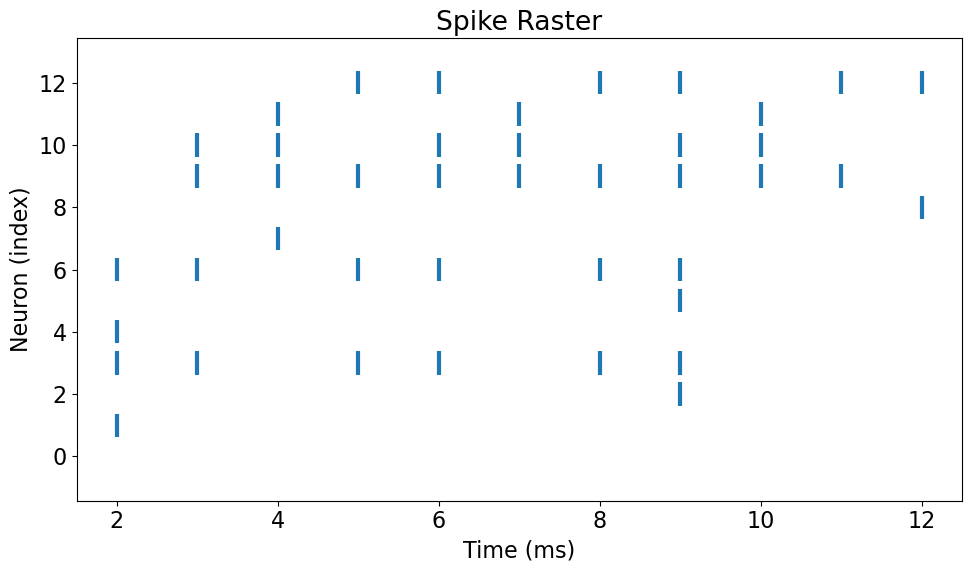

In [16]:
# Plot the event data
fig, axs = plt.subplots(1,1,figsize=(10,6))
axs.eventplot(evtlist,lineoffsets=1,linelengths=0.75,linewidths=3.0)
plt.title('Spike Raster')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron (index)')
plt.tight_layout()

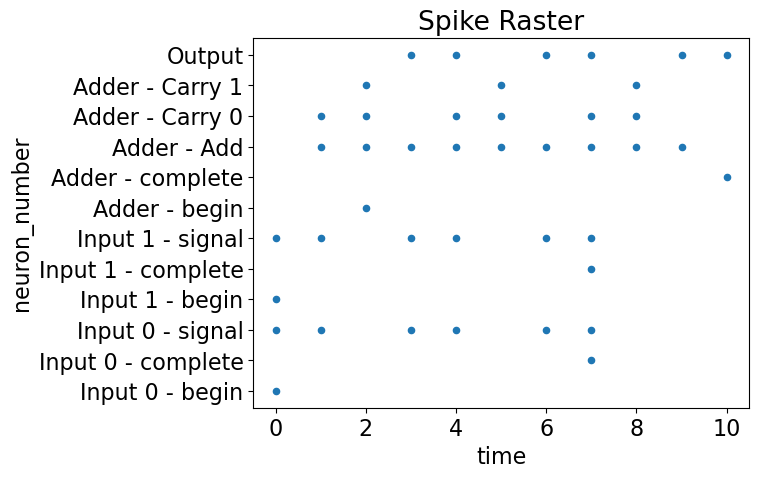

In [17]:
# Just to compare against the Fugu/SNN backend simulated circuit
result.plot.scatter(x='time', y='neuron_number', title="Spike Raster")
plt.yticks(np.arange(12), ['Input 0 - begin', 'Input 0 - complete', 'Input 0 - signal', 'Input 1 - begin', 'Input 1 - complete', 'Input 1 - signal', 'Adder - begin', 'Adder - complete', 'Adder - Add', 'Adder - Carry 0', 'Adder - Carry 1', 'Output'])
plt.show()